# Check the initial nowcast experiment

In [2]:
import pandas as pd
from pathlib import Path
import xarray as xr
import numpy as np
# colormaps = https://matplotlib.org/cmocean/
import cmocean
import matplotlib.pyplot as plt
import geopandas as gpd
from typing import List, Tuple, Dict, Union, Optional

import matplotlib as mpl
import seaborn as sns
mpl.rcParams['figure.dpi'] = 100

import os

# set the working directory
current_path = Path('.').resolve()
if current_path == Path('/home/tommy/ml_drought/notebooks/draft'):
    os.chdir(current_path.parents[1].as_posix())

current_path = Path('.').resolve()
assert current_path.name == "ml_drought"

%load_ext autoreload
%autoreload 2

In [3]:
from scripts.utils import get_data_path
from src.engineer import Engineer
from src.utils import get_ds_mask
from src.utils import drop_nans_and_flatten

In [4]:
data_dir = get_data_path()
EXPERIMENT = experiment = "nowcast"

# Load the forecast engineered data

In [5]:
from scripts.models import get_all_vars, get_forecast_vars, get_ignore_static_vars

forecast_vars = get_forecast_vars()
ignore_static_vars = get_ignore_static_vars()
x_vars, y_var = get_all_vars(experiment="nowcast")
ignore_dyn_vars = np.array(x_vars)[~np.isin(x_vars, forecast_vars + [y_var])]

ignore_vars = list(ignore_dyn_vars) + ignore_static_vars

In [6]:
from src.engineer import Engineer

engineer = Engineer(
    get_data_path(), experiment=experiment, process_static=True
)
e = engineer.engineer_class
data = e._make_dataset(static=False)
static = e._make_dataset(static=True)

# ignore the ignore variables
data = data.drop([v for v in ignore_vars if v in data.data_vars])
static = static.drop([v for v in ignore_vars if v in static.data_vars])

Processing /cats/datastore/data/interim/VCI_preprocessed/data_india.nc
Processing /cats/datastore/data/interim/reanalysis-era5-land-monthly-means_preprocessed/volumetric_soil_water_layer_1_data_india.nc
Processing /cats/datastore/data/interim/reanalysis-era5-land-monthly-means_preprocessed/volumetric_soil_water_layer_2_data_india.nc
Processing /cats/datastore/data/interim/reanalysis-era5-land-monthly-means_preprocessed/volumetric_soil_water_layer_3_data_india.nc
Processing /cats/datastore/data/interim/reanalysis-era5-land-monthly-means_preprocessed/volumetric_soil_water_layer_4_data_india.nc
Processing /cats/datastore/data/interim/reanalysis-era5-land-monthly-means_preprocessed/potential_evaporation_data_india.nc
Processing /cats/datastore/data/interim/reanalysis-era5-land-monthly-means_preprocessed/total_precipitation_data_india.nc
Processing /cats/datastore/data/interim/reanalysis-era5-land-monthly-means_preprocessed/2m_temperature_data_india.nc
Processing /cats/datastore/data/interi

# load in the model predictions

In [7]:
from src.analysis import read_train_data, read_test_data, read_pred_data
from scripts.analysis import read_all_data, read_all_available_pred_data, load_nn, create_all_error_metrics, create_matching_shapes_in_predictions_dict

In [ ]:
X_train, y_train, X_test, y_test = read_all_data(
    data_dir, experiment=experiment, 
)

In [ ]:
mask = get_ds_mask(X_train.VCI)

In [ ]:
predictions = read_all_available_pred_data(data_dir, experiment=experiment)

#  check that the shapes of all predictions are the same
if not set([predictions[m].shape for m in predictions.keys()]).__len__() == 1:
    predictions = create_matching_shapes_in_predictions_dict(
        predictions,
        verbose=True
    )
    
assert set([predictions[m].shape for m in predictions.keys()]).__len__() == 1
preds = predictions[list(m for m in predictions.keys())[-1]]

# get the matching shapes from predictions and test data
test_da = y_test[list(y_test.data_vars)[0]]
test_da = test_da.sel(lat=preds.lat, lon=preds.lon, time=preds.time)

## Read in the one month forecast predictions to compare directly

## Calculate Error Metrics

In [ ]:
rmse_dict, r2_dict = create_all_error_metrics(predictions, test_da)

In [ ]:
kwargs = dict(vmin=0, vmax=20, cmap="viridis")

fig, axs = plt.subplots(1, 4, figsize=(6*4, 4))
for i, key in enumerate(rmse_dict.keys()):
    ax = axs[i]
    rmse_dict[key].plot(ax=ax, **kwargs)
    ax.set_title(str(key))  
    ax.axis('off')

In [ ]:
fig, axs = plt.subplots(1, 4, figsize=(6*4, 4))
for i, var in enumerate(["tprate_mean_1", "tprate_mean_2", "erate_mean_1", "erate_mean_2"]):
    ax = axs[i]
    kwargs = {"vmin":0, "vmax": 2e-7, "cmap": "viridis"} if "tprate" in var else {"vmin":-7e-8, "vmax":0, "cmap": "plasma"}
    data[var].isel(time=-10).where(~mask).plot(ax=ax, **kwargs)
    ax.set_title(str(var))  
    ax.axis('off')

In [ ]:
fig, ax = plt.subplots()
data["VCI"].isel(time=-10).where(~mask).plot(ax=ax)
ax.axis('off')
time = ax.get_title()
ax.set_title(f"VCI: {time}");

## Calculate overall performances

In [ ]:
pd.DataFrame({
    "model": [model for (model, da) in r2_dict.items()],
    "median_r2": [float(da.median().values) for (model, da) in r2_dict.items()]
})

In [ ]:
pd.DataFrame({
    "model": [model for (model, da) in rmse_dict.items()],
    "median_rmse": [float(da.median().values) for (model, da) in rmse_dict.items()]
})

### Compare overall model performances

In [ ]:
# from scripts.utils import load_pickle, pickle_file
import pickle

def load_pickle(filepath):
    """ load a pickled object from the filepath """
    with open(filepath, "rb") as f:
        return pickle.load(f)
    
    
r2_dict_001 = load_pickle(data_dir / "tommy/001_one_month_forecast_r2_dict.pkl")
rmse_dict_001 = load_pickle(data_dir / "tommy/001_one_month_forecast_rmse_dict.pkl")

In [ ]:
r2_001 = pd.DataFrame({
    "model": [model for (model, da) in r2_dict_001.items()],
    "median_r2": [float(da.median().values) for (model, da) in r2_dict_001.items()]
})
r2_001["experiment"] = "original"

rmse_001 = pd.DataFrame({
    "model": [model for (model, da) in rmse_dict_001.items()],
    "median_rmse": [float(da.median().values) for (model, da) in rmse_dict_001.items()]
})
rmse_001["experiment"] = "original"

r2_002 = pd.DataFrame({
    "model": [model for (model, da) in r2_dict.items()],
    "median_r2": [float(da.median().values) for (model, da) in r2_dict.items()]
}).query("model != 'linear_network'")
r2_002["experiment"] = "seas5"

rmse_002 = pd.DataFrame({
    "model": [model for (model, da) in rmse_dict.items()],
    "median_rmse": [float(da.median().values) for (model, da) in rmse_dict.items()]
}).query("model != 'linear_network'")
rmse_002["experiment"] = "seas5"

In [ ]:
sns.barplot(x="model", y="median_r2", hue="experiment", data=pd.concat([r2_001, r2_002]))
sns.despine()

In [ ]:
sns.barplot(x="model", y="median_rmse", hue="experiment", data=pd.concat([rmse_001, rmse_002]))
sns.despine()

# Explore the RAW Predictions (are they blocky ..?)

In [ ]:
original_predictions = load_pickle(data_dir / "tommy/001_one_month_forecast_preds_dict.pkl")

rnn = predictions["rnn"]
orig_rnn = original_predictions["rnn"].drop("month")
ealstm = predictions["ealstm"]
orig_ealstm = original_predictions["ealstm"].drop("month")

### Making animations

- http://christopherbull.com.au/mkmov/
- https://climate-cms.org/2019/09/03/python-animation.html

In [ ]:
(data_dir / "tommy").exists()

(data_dir / "tommy/plots").mkdir(exist_ok=True, parents=True)

In [ ]:
difference = orig_ealstm - ealstm

In [ ]:
def plot_all_data(axs, time_ix):
    orig_ealstm.isel(time=time_ix).plot(
        ax=axs[0], vmin=0, vmax=100,
        cbar_kwargs={'extend':'neither'},
    );
    axs[0].axis('off')
    axs[0].set_title(f"Original Experiment: {axs[0].get_title()}");

    ealstm.isel(time=time_ix).plot(
        ax=axs[1], vmin=0, vmax=100,
        cbar_kwargs={'extend':'neither'},
    );
    axs[1].axis('off')
    axs[1].set_title(f"SEAS5 Experiment: {axs[1].get_title()}");
    
    # POSITIVE = Orig>S5; NEGATIVE = Orig<S5;
    difference.isel(time=time_ix).plot(
        ax=axs[2], vmin=-30, vmax=30, cmap="RdBu_r",
        cbar_kwargs={'extend':'neither'},
    )
    axs[2].axis('off')
    axs[2].set_title(f"$Original - SEAS5$");

    return axs

In [ ]:
for time_ix in range(rnn.time.shape[0]):
    fig, axs = plt.subplots(1, 3, figsize=(6*3, 4))

    plot_all_data(axs, time_ix)
    for ax in axs:
        ax.axis('off')
    
    # --- REMOVE THIS --- # 
    break

    fig.savefig(data_dir / f"tommy/plots/{time_ix:03}.png")
    
    plt.close('all')

In [ ]:
# !convert -delay 75 /cats/datastore/data/tommy/plots/*png /cats/datastore/data/tommy/plots/animation.gif

In [ ]:
difference

# Join Metrics to Region DataFrame

In [237]:
l1_gdf = gpd.read_file(data_dir / "raw/boundaries/india/IND_adm1.shp")
l2_gdf = gpd.read_file(data_dir / "raw/boundaries/india/IND_adm2.shp")

l1_mask = xr.open_dataset(data_dir / "analysis/boundaries_preprocessed/state_l1_india.nc")
l2_mask = xr.open_dataset(data_dir / "analysis/boundaries_preprocessed/district_l2_india.nc")

l1_lookup = dict(zip(
    [int(k.lstrip().rstrip()) for k in l1_mask.attrs["keys"].split(',')], 
    [k.lstrip().rstrip() for k in l1_mask.attrs["values"].split(',')]
))
l2_lookup = dict(zip(
    [int(k.lstrip().rstrip()) for k in l2_mask.attrs["keys"].split(',')], 
    [k.lstrip().rstrip() for k in l2_mask.attrs["values"].split(',')]
))

### Creating the R2/RMSE GeoDataFrames

In [238]:
from scripts.analysis import get_mean_timeseries_per_region

In [239]:
assert (data_dir / "tommy").exists(), "Require data_dir / 'tommy' to save csv copy of data"

# takes a while to run so save it if it doesn't exist already
if not (data_dir / "tommy/l1_state_mean_timeseries_001.csv").exists():
    state_df = get_mean_timeseries_per_region(level=1)
    state_df.to_csv(data_dir / "tommy/l1_state_mean_timeseries_001.csv")
else:
    state_df = pd.read_csv(data_dir / "tommy/l1_state_mean_timeseries_001.csv").drop("Unnamed: 0", axis=1)

In [240]:
if not (data_dir / "tommy/l2_district_mean_timeseries_001.csv").exists():
    district_df = get_mean_timeseries_per_region(level=2)
    district_df.to_csv(data_dir / "tommy/l2_district_mean_timeseries_001.csv")
else:
    district_df = pd.read_csv(data_dir / "tommy/l2_district_mean_timeseries_001.csv").drop("Unnamed: 0", axis=1)

In [241]:
from scripts.analysis import create_mean_pixel_errors_gdf

In [242]:
## -- Level 1 --
l1_rmse_gdf = create_mean_pixel_errors_gdf(
    metric_dict=rmse_dict,
    region_gdf=l1_gdf,
    gdf_name_col="NAME_1",
    region_mask=l1_mask,
)

l1_r2_gdf = create_mean_pixel_errors_gdf(
    metric_dict=r2_dict,
    region_gdf=l1_gdf,
    gdf_name_col="NAME_1",
    region_mask=l1_mask,
)


## -- Level 2 --
l2_rmse_gdf = create_mean_pixel_errors_gdf(
    metric_dict=rmse_dict,
    region_gdf=l2_gdf,
    gdf_name_col="NAME_2",
    region_mask=l2_mask,
)

l2_r2_gdf = create_mean_pixel_errors_gdf(
    metric_dict=r2_dict,
    region_gdf=l2_gdf,
    gdf_name_col="NAME_2",
    region_mask=l2_mask,
)

/home/tommy/miniconda3/envs/ml/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/home/tommy/miniconda3/envs/ml/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/home/tommy/miniconda3/envs/ml/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/home/tommy/miniconda3/envs/ml/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/home/tommy/miniconda3/envs/ml/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/home/tommy/miniconda3/envs/ml/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis,

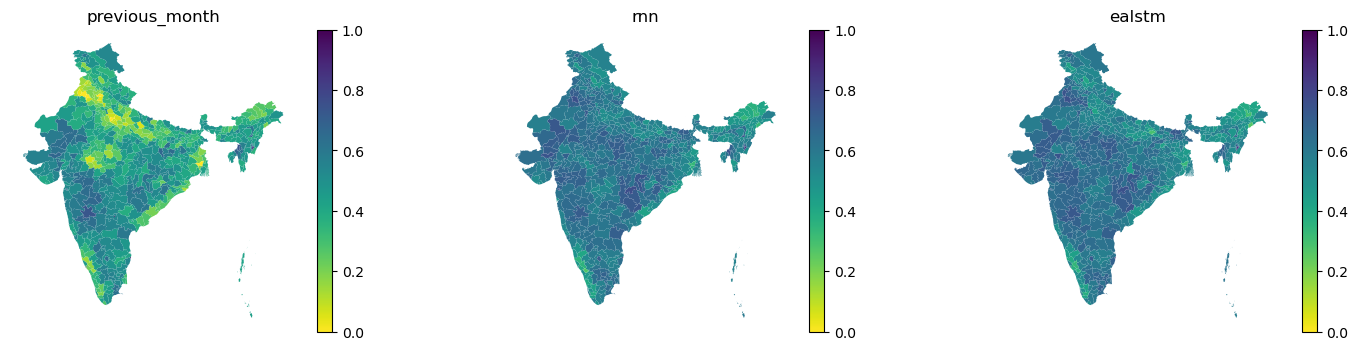

In [246]:
kwargs = {"vmin": 0, "vmax": 1, "cmap": "viridis_r"}

fig, axs = plt.subplots(1, 3, figsize=(6*3, 4))
for i, model in enumerate([c for c in l2_r2_gdf.columns if c not in ["region_name", "geometry", "index", "linear_network"]]):
    ax = axs[i]
    l2_r2_gdf.plot(model, legend=True, ax=ax, **kwargs)
    ax.set_title(model)
    
    ax.axis('off')

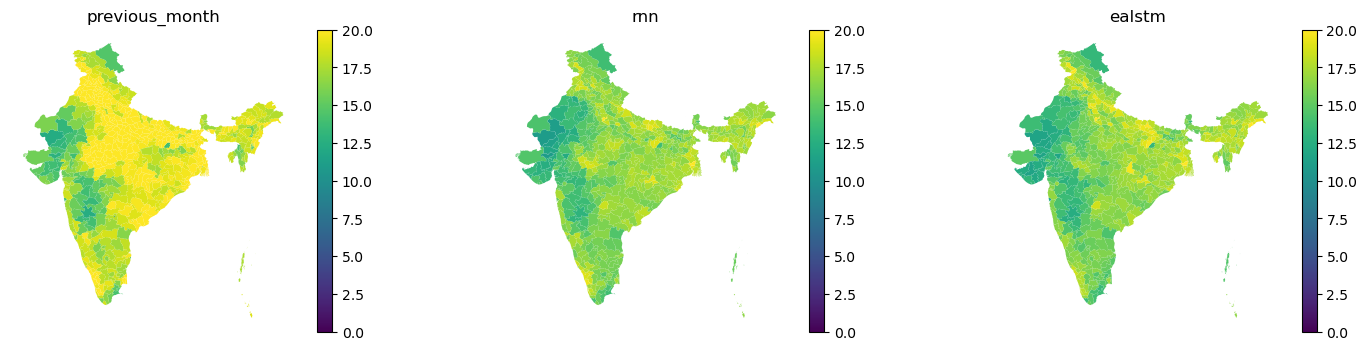

In [247]:
kwargs = {"vmin": 0, "vmax": 20, "cmap": "viridis"}

fig, axs = plt.subplots(1, 3, figsize=(6*3, 4))
for i, model in enumerate([c for c in l2_r2_gdf.columns if c not in ["region_name", "geometry", "index", "linear_network"]]):
    ax = axs[i]
    l2_rmse_gdf.plot(model, legend=True, ax=ax, **kwargs)
    ax.set_title(model)
    
    ax.axis('off')

# MARGINALIA

In [ ]:
from matplotlib import pyplot as plt, animation


def plot_original_time(ax, time_ix):
    # plot the original data
    orig_ealstm.isel(time=time_ix).plot(
        ax=ax, vmin=0, vmax=100,
        cbar_kwargs={'extend':'neither'},
    );
    ax.set_title(f"Original Experiment: {ax.get_title()}");
    
    return ax

def plot_SEAS5_time(ax, time_ix):
    # plot the SEAS5 data
    ealstm.isel(time=time_ix).plot(
        ax=ax, vmin=0, vmax=100,
        cbar_kwargs={'extend':'neither'},
    );
    ax.set_title(f"Seas5 Experiment: {ax.get_title()}");
    return ax


# Get a handle on the figure and the axes
fig, axs = plt.subplots(1, 2, figsize=(6*2, 4))

# Plot the initial frame. 
axs[0] = plot_original_time(axs[0], 0)
axs[1] = plot_SEAS5_time(axs[1], 0)

# Next we need to create a function that updates the values for the colormesh, as well as the title.
def animate(frame):
    axs[0].set_array(orig_ealstm.isel(time=frame).values)
    axs[1].set_array(ealstm.isel(time=frame).values)

# Finally, we use the animation module to create the animation.
ani = animation.FuncAnimation(
    fig,             # figure
    animate,         # name of the function above
    frames=40,       # Could also be iterable or list
    interval=200     # ms between frames
)

# show as javascript html ...
# HTML(ani.to_jshtml())